In [1]:
import pandas as pd

In [2]:
pred_PLS_SM = pd.read_csv("./data/data/PLS_SM/tar_pred.csv")
pred_PLS_SM.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

pred_ICA = pd.read_csv("./data/data/jade/ica/tar_pred.csv")
pred_ICA["Sample Name"] = pred_ICA["target"]
pred_ICA.drop(columns=["target"], axis=1, inplace=True)

In [3]:
pred_ICA.columns

Index(['ID', 'SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O',
       'Sample Name'],
      dtype='object')

In [4]:
pred_ICA.head()

,ID,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name
0,vs211681_2013_09_03_173153_ccs,49.150000,1.650000,16.530000,9.960000,6.560000,8.870000,3.740000,0.98000,vs211681
1,r11_2013_11_04_154730_ccs,65.600000,0.570000,18.100000,4.270000,2.260000,0.940000,1.340000,4.18000,r11
2,jsc1466_2013_09_19_142647_ccs,43.220000,2.520000,13.310000,11.770000,10.200000,7.200000,3.380000,2.26000,jsc1466
3,jsc1421_2013_09_12_210811_ccs,56.130000,0.690000,17.690000,5.860000,3.850000,7.070000,3.320000,1.44000,jsc1421
4,mc_2013_10_24_141939_ccs,54.722706,1.107092,19.177926,5.019485,6.454927,-0.356965,0.015848,3.90835,mc


In [5]:
ids_to_keep = pred_ICA["ID"]
filtered_pred_PLS_SM = pred_PLS_SM[pred_PLS_SM['ID'].isin(ids_to_keep)]

In [6]:
filtered_pred_PLS_SM.set_index("ID", inplace=True)
pred_ICA.set_index("ID", inplace=True)

In [7]:
aligned_pred_PLS_SM, aligned_pred_ICA = filtered_pred_PLS_SM.align(pred_ICA, join="inner", axis=0)

In [8]:
aligned_pred_PLS_SM

,Sample Name,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O
ID,,,,,,,,,
pl7_2013_10_30_151012_ccs,pl7,52.062145,1.013626,17.67621,8.723337,6.074096,4.348543,2.480036,2.774704
201429_2013_11_07_143035_ccs,201429,51.908430,1.191408,17.67621,8.579252,6.083016,4.254298,2.480036,2.774704
mc_2013_10_24_141939_ccs,mc,52.066618,1.000076,17.67621,8.710583,6.085949,4.388767,2.480036,2.774704
jdo1_2013_08_13_151800_ccs,jdo1,52.242225,0.900180,17.67621,8.716817,6.078445,4.338996,2.480036,2.774704
gbw07313_2013_08_07_195225_ccs,gbw07313,51.882951,0.976427,17.67621,8.729067,6.069386,4.430285,2.480036,2.774704
...,...,...,...,...,...,...,...,...,...
ps4_2013_10_30_153406_ccs,ps4,52.102819,0.933715,17.67621,8.722625,6.077599,4.422717,2.480036,2.774704
lp30_2013_10_23_180233_ccs,lp30,52.115001,0.993638,17.67621,8.737943,6.074723,4.324827,2.480036,2.774704
jsc1418_2013_09_12_201534_ccs,jsc1418,52.328142,0.808160,17.67621,8.776682,6.074758,4.463746,2.480036,2.774704


In [9]:
from lib.reproduction import weighted_sum_oxide_percentages, major_oxides

merged_df = pd.merge(aligned_pred_ICA, aligned_pred_PLS_SM, on='Sample Name', suffixes=('_ICA', '_PLS_SM'))
moc_predictions = pd.DataFrame()

for oxide in major_oxides:
    w_ica = weighted_sum_oxide_percentages[oxide]['ICA'] / 100
    w_pls_sm = weighted_sum_oxide_percentages[oxide]['PLS1-SM'] / 100
    moc_predictions[oxide] = merged_df[oxide + '_ICA'] * w_ica + merged_df[oxide + '_PLS_SM'] * w_pls_sm

moc_predictions['Sample Name'] = merged_df['Sample Name']
moc_predictions['ID'] = aligned_pred_ICA.index

In [10]:
moc_predictions

,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,59.436073,0.901813,17.404657,7.637503,3.932048,2.484271,1.310014,3.378676,pl7,pl7_2013_10_30_151012_ccs
1,52.154215,1.425704,19.454657,8.264439,4.696508,3.932149,3.380014,1.991176,201429,201429_2013_11_07_143035_ccs
2,53.394662,1.053584,18.051639,7.787809,6.270438,2.015901,1.001523,3.624938,mc,mc_2013_10_24_141939_ccs
3,26.231113,0.450090,13.259657,6.560113,12.239222,19.229498,0.998014,0.693676,jdo1,jdo1_2013_08_13_151800_ccs
4,52.871475,0.823213,16.694657,8.099301,4.724693,3.070142,3.878014,2.906176,gbw07313,gbw07313_2013_08_07_195225_ccs
...,...,...,...,...,...,...,...,...,...,...
69,65.051410,0.671858,15.669657,6.859469,3.333799,2.341359,1.400014,2.396176,ps4,ps4_2013_10_30_153406_ccs
70,57.557500,0.851819,17.507157,8.195957,5.737362,3.112414,1.688014,3.431176,lp30,lp30_2013_10_23_180233_ccs
71,70.354071,0.409080,13.359657,8.975011,3.092379,2.266873,0.992014,0.701176,jsc1418,jsc1418_2013_09_12_201534_ccs
72,49.575764,1.367889,16.785110,8.667671,8.033724,6.291592,2.952893,2.535866,jsc1430,jsc1430_2013_09_16_160043_ccs


In [11]:
from lib.data_handling import CompositionData

cd = CompositionData("data/data/calib/ccam_calibration_compositions.csv")

In [12]:
def merge_with_actual_data(moc_predictions):
    merged_data = pd.DataFrame()

    for index, row in moc_predictions.iterrows():
        actual_data = cd.get_composition_for_sample(row['Sample Name'])

        if not actual_data.empty:
            for oxide in major_oxides:
                merged_data.at[index, oxide + '_pred'] = row[oxide]
                merged_data.at[index, oxide + '_actual'] = actual_data[oxide].values[0]
            merged_data.at[index, 'Sample Name'] = row['Sample Name']

    return merged_data

In [13]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(merged_data):
    rmse_values = {}
    for oxide in major_oxides:
        y_actual = merged_data[oxide + '_actual']
        y_pred = merged_data[oxide + '_pred']
        rmse = mean_squared_error(y_actual, y_pred, squared=False)
        rmse_values[oxide] = rmse
    return rmse_values

# Usage example
merged_moc_actual_df = merge_with_actual_data(moc_predictions)
moc_rmse_values = calculate_rmse(merged_moc_actual_df)

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

In [14]:
SiO2_eval_df = pd.merge(merged_df[["SiO2_ICA", "SiO2_PLS_SM", "Sample Name"]], 
                    merged_moc_actual_df[["SiO2_actual", "SiO2_pred", "Sample Name"]], 
                    on="Sample Name")

SiO2_eval_df = SiO2_eval_df[0:5]
SiO2_eval_df

,SiO2_ICA,SiO2_PLS_SM,Sample Name,SiO2_actual,SiO2_pred
0,66.810000,52.062145,pl7,66.81,59.436073
1,52.400000,51.908430,201429,52.4,52.154215
2,54.722706,52.066618,mc,47.11,53.394662
3,0.220000,52.242225,jdo1,0.22,26.231113
4,53.860000,51.882951,gbw07313,53.86,52.871475


/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

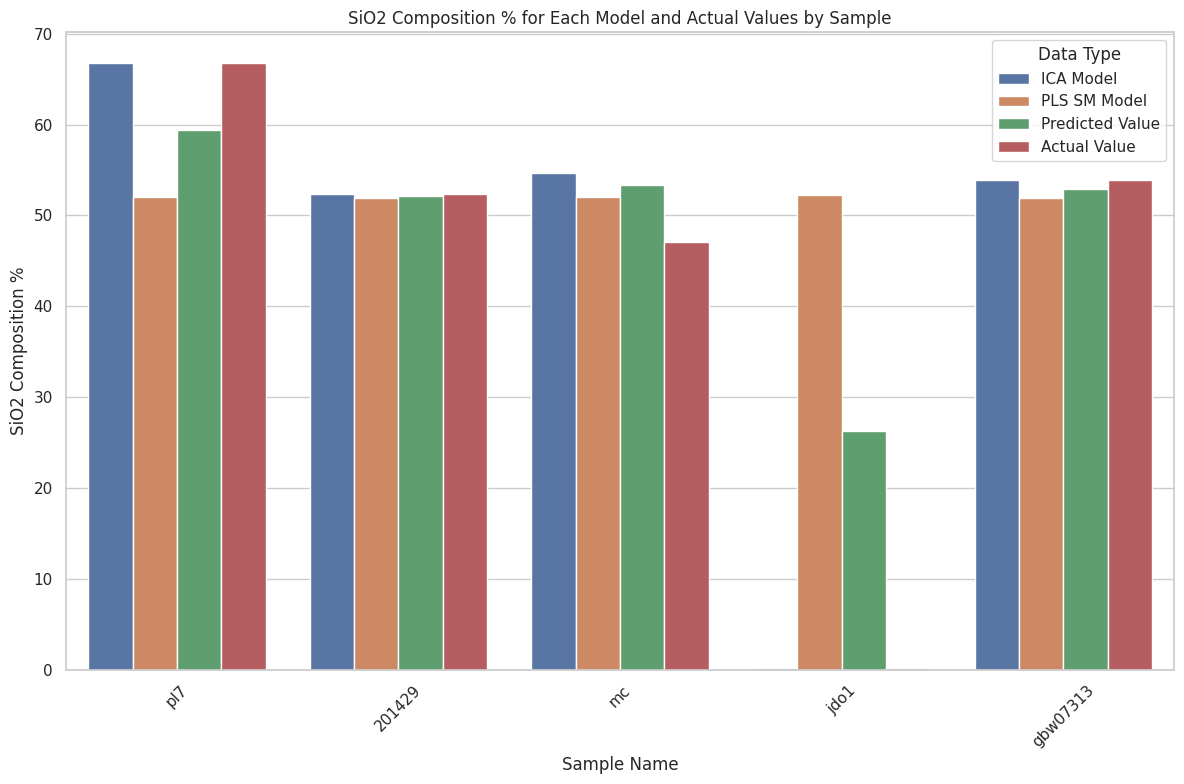

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plot
sns.set(style="whitegrid")

# Creating a figure for the plot
plt.figure(figsize=(12, 8))

# Creating aliases for the value_vars
aliases = {
    'SiO2_ICA': 'ICA Model',
    'SiO2_PLS_SM': 'PLS SM Model',
    'SiO2_pred': 'Predicted Value',
    'SiO2_actual': 'Actual Value'
}

# Merging the data for actual and predicted values for the plot
melted_data = pd.melt(SiO2_eval_df, id_vars='Sample Name', value_vars=list(aliases.keys()))

# Renaming the columns based on aliases
melted_data = melted_data.rename(columns={'variable': 'Model/Value', 'value': 'SiO2 Composition %'})
melted_data['Model/Value'] = melted_data['Model/Value'].map(aliases)

# Creating the grouped bar chart
sns.barplot(x='Sample Name', y='SiO2 Composition %', hue='Model/Value', data=melted_data)

# Adding labels and title
plt.xlabel('Sample Name')
plt.ylabel('SiO2 Composition %')
plt.title('SiO2 Composition % for Each Model and Actual Values by Sample')
plt.xticks(rotation=45)
plt.legend(title='Data Type')

plt.gca().invert_yaxis()

# Displaying the plot
plt.tight_layout()
plt.show()

In [16]:
merged_moc_actual_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
0,59.436073,66.81,0.901813,0.79,17.404657,16.59,7.637503,4.38,3.932048,1.79,2.484271,0.62,1.310014,0.53,3.378676,3.58,pl7
1,52.154215,52.4,1.425704,1.66,19.454657,24.79,8.264439,7.32,4.696508,3.31,3.932149,3.61,3.380014,3.98,1.991176,1.73,201429
2,53.394662,47.11,1.053584,1.06,18.051639,27.15,7.787809,7.69,6.270438,4.98,2.015901,0.03,1.001523,0.88,3.624938,4.76,mc
3,26.231113,0.22,0.450090,0,13.259657,0.01,6.560113,0.09,12.239222,18.4,19.229498,34.12,0.998014,0.01,0.693676,0,jdo1
4,52.871475,53.86,0.823213,0.67,16.694657,13.75,8.099301,6.21,4.724693,3.38,3.070142,1.71,3.878014,4.81,2.906176,2.95,gbw07313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,65.051410,78,0.671858,0.41,15.669657,9.65,6.859469,1.27,3.333799,0.59,2.341359,0.26,1.400014,0.68,2.396176,2.27,ps4
70,57.557500,63,0.851819,0.71,17.507157,17.00,8.195957,6.57,5.737362,5.4,3.112414,1.90,1.688014,1.16,3.431176,3.65,lp30
71,70.354071,88.38,0.409080,0.01,13.359657,0.41,8.975011,9.57,3.092379,0.11,2.266873,0.07,0.992014,0,0.701176,0.01,jsc1418
72,49.575764,54.56,1.367889,1.16,16.785110,17.43,8.667671,6.31,8.033724,4.41,6.291592,7.22,2.952893,3.86,2.535866,1.85,jsc1430


In [17]:
moc_rmse_values

{'SiO2': 10.136583236420615,
 'TiO2': 0.3574732953518164,
 'Al2O3': 5.607935776201255,
 'FeOT': 7.295412971962815,
 'MgO': 2.8991158033923097,
 'CaO': 3.6889807330479982,
 'Na2O': 1.0311779564347998,
 'K2O': 0.8266429707454264}

In [18]:
ICA_actual_merged_df = merge_with_actual_data(aligned_pred_ICA)
ICA_rmses = calculate_rmse(ICA_actual_merged_df)

PLS_SM_actual_merged_df = merge_with_actual_data(aligned_pred_PLS_SM)
PLS_SM_rmses = calculate_rmse(PLS_SM_actual_merged_df)

ICA_rmses

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

{'SiO2': 5.221888897312351,
 'TiO2': 0.28205514981461993,
 'Al2O3': 2.0699913045689544,
 'FeOT': 2.460072539150486,
 'MgO': 1.3990096136336276,
 'CaO': 2.012868723226939,
 'Na2O': 0.9069721555409199,
 'K2O': 0.6542748064416937}

In [19]:
PLS_SM_actual_merged_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
pl7_2013_10_30_151012_ccs,52.062145,66.81,1.013626,0.79,17.67621,16.59,8.723337,4.38,6.074096,1.79,4.348543,0.62,2.480036,0.53,2.774704,3.58,pl7
201429_2013_11_07_143035_ccs,51.908430,52.4,1.191408,1.66,17.67621,24.79,8.579252,7.32,6.083016,3.31,4.254298,3.61,2.480036,3.98,2.774704,1.73,201429
mc_2013_10_24_141939_ccs,52.066618,47.11,1.000076,1.06,17.67621,27.15,8.710583,7.69,6.085949,4.98,4.388767,0.03,2.480036,0.88,2.774704,4.76,mc
jdo1_2013_08_13_151800_ccs,52.242225,0.22,0.900180,0,17.67621,0.01,8.716817,0.09,6.078445,18.4,4.338996,34.12,2.480036,0.01,2.774704,0,jdo1
gbw07313_2013_08_07_195225_ccs,51.882951,53.86,0.976427,0.67,17.67621,13.75,8.729067,6.21,6.069386,3.38,4.430285,1.71,2.480036,4.81,2.774704,2.95,gbw07313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ps4_2013_10_30_153406_ccs,52.102819,78,0.933715,0.41,17.67621,9.65,8.722625,1.27,6.077599,0.59,4.422717,0.26,2.480036,0.68,2.774704,2.27,ps4
lp30_2013_10_23_180233_ccs,52.115001,63,0.993638,0.71,17.67621,17.00,8.737943,6.57,6.074723,5.4,4.324827,1.90,2.480036,1.16,2.774704,3.65,lp30
jsc1418_2013_09_12_201534_ccs,52.328142,88.38,0.808160,0.01,17.67621,0.41,8.776682,9.57,6.074758,0.11,4.463746,0.07,2.480036,0,2.774704,0.01,jsc1418
jsc1430_2013_09_16_160043_ccs,51.965246,54.56,1.107944,1.16,17.67621,17.43,8.634797,6.31,6.062610,4.41,4.335159,7.22,2.480036,3.86,2.774704,1.85,jsc1430


In [20]:
PLS_SM_rmses

{'SiO2': 17.785256611502,
 'TiO2': 0.6006596630421887,
 'Al2O3': 7.257861908475539,
 'FeOT': 9.303939961221312,
 'MgO': 5.540767414080896,
 'CaO': 6.830727353503157,
 'Na2O': 1.753884102219781,
 'K2O': 2.160388213583431}

In [21]:
RMSEs_df = pd.DataFrame([ICA_rmses, PLS_SM_rmses, moc_rmse_values], index=["ICA", "PLS_SM", "MOC"])

In [22]:
RMSEs_df.T

,ICA,PLS_SM,MOC
SiO2,5.221889,17.785257,10.136583
TiO2,0.282055,0.600660,0.357473
Al2O3,2.069991,7.257862,5.607936
FeOT,2.460073,9.303940,7.295413
MgO,1.399010,5.540767,2.899116
CaO,2.012869,6.830727,3.688981
Na2O,0.906972,1.753884,1.031178
K2O,0.654275,2.160388,0.826643


In [28]:
# find moc prediction for sample name including the word "nau2"
nau2los_moc_df = merged_moc_actual_df[merged_moc_actual_df['Sample Name'].str.contains("nau2")]

# calculate rmse 
calculate_rmse(nau2los_moc_df)

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

{'SiO2': 4.170330740076537,
 'TiO2': 0.07967209777061168,
 'Al2O3': 7.534657287550833,
 'FeOT': 7.143523044169983,
 'MgO': 1.5475562174126716,
 'CaO': 1.9630939512917474,
 'Na2O': 0.41601448326690216,
 'K2O': 0.5936760119267454}